NeRF pytorch 实现

In [1]:
import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
data=np.load("tiny_nerf_data.npz")

In [3]:
images=data['images']
poses=data['poses']
focal=data['focal']

In [4]:
ImgTensor=torch.tensor(images)
posesTensor=torch.tensor(poses)
focalTensor=torch.tensor(focal)

ImgTensor=ImgTensor[:100,:,:,:]
posesTensor=posesTensor[:100,:,:]


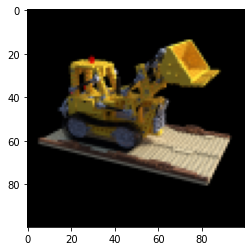

In [5]:
plt.imshow(ImgTensor[2])

In [6]:
def posEnc(x,l):
#     x=torch.tensor(x)
    gama=[x]
    for i in range(l):           
            gama.append(torch.cos((2**i)*torch.pi*x))
            gama.append(torch.sin((2**i)*torch.pi*x)) 
    return torch.concat(gama,-1)


In [7]:
def getRay(pose,H,W,pixSize,Focus):
    xs = torch.linspace(-W/2*pixSize, W/2*pixSize, steps=W,dtype=float)
    ys = torch.linspace(-H/2*pixSize, H/2*pixSize, steps=H,dtype=float)
    camLoc=torch.meshgrid(xs,ys)
    dir=torch.zeros([W,H,3])
    dir[:,:,0]=camLoc[1]/Focus
    dir[:,:,1]=-camLoc[0]/Focus
    dir[:,:,2]=-1
    print(pose[np.newaxis,np.newaxis,:3,:3].shape)
    ray_d=torch.matmul(pose[np.newaxis,np.newaxis,:3,:3],dir[...,np.newaxis])
    ray_o=pose[:3,-1].broadcast_to(W,H,3)
    return ray_o,ray_d[...,0]



In [8]:
class NeRFmodel(torch.nn.Module):
    def __init__(self,lx,ld,W):
        super().__init__()
        self.MLPinput=torch.nn.Linear(lx+ld+3,W)
        self.MLPmid0=torch.nn.Sequential(*self.MLPstd(4,256))
        self.Denseout=torch.nn.Linear(W+lx+ld+3,W)
        self.MLPmid1=torch.nn.Sequential(*self.MLPstd(2,256))      
        self.Modelout=torch.nn.Linear(W,4)
        self.relu=torch.nn.ReLU()
    def MLPstd(self,numsLayer,width):
        mlpstd=[]
        for i in range(numsLayer,):
          mlpstd.append(torch.nn.Linear(width,width))
          mlpstd.append(torch.nn.ReLU())
        return mlpstd
    def forward(self,X):
        x0=self.relu(self.MLPinput(X))
        x0=self.MLPmid0(x0)
        x0=self.relu(self.Denseout(torch.concat([x0,X],-1)))
        x0=self.MLPmid1(x0)
        output=self.Modelout(x0)
        return output
        

In [9]:
def renderRayCoast(net,rayO,rayD,near,far,numSam):
    def batch_rend(fn,chunkSize=1024*32):
        return lambda input : torch.concat([fn(input[i:i+chunkSize,...]) for i in range(0,input.shape[0],chunkSize)],0)
    #随机采样稀疏点
    tLayer=torch.linspace(near,far,numSam)
    rayT=tLayer+torch.rand(numSam)*((far-near)/numSam)
    points = rayO[...,None,:]+rayD[...,None,:]*rayT[:,None]

    flatPoints=torch.reshape(points,(-1,points.shape[-1]))
    #位置编码+MLP渲染
    enc=posEnc(flatPoints,6)
    modelOut=batch_rend(net)(enc)
    modelOut=torch.reshape(modelOut,(points.shape[0],points.shape[1],numSam,-1))
    sigma=torch.relu(modelOut[...,3])
    rgb=torch.sigmoid(modelOut[...,:3])
 
    return rayT,sigma,rgb
def renderRayFine(net,rayT,sigma,numSam):
    dt=torch.concat([torch.diff(rayT),torch.tensor(1e10).broadcast_to(1)])
    alfa=torch.exp(-sigma*dt)
    T=torch.concat([torch.zeros_like(alfa,dtype=float)[...,:1],torch.cumprod(alfa + 1e-10,dim=-1)[...,:-1]],dim=-1)
    weight=T*(1.-alfa )
    return weight


def rgb2output(rayT,sigma,rgb):
    dt=torch.concat([torch.diff(rayT),torch.tensor(1e10).broadcast_to(1)])
    alfa=torch.exp(-sigma*dt)
    T=torch.concat([torch.zeros_like(alfa,dtype=float)[...,:1],torch.cumprod(alfa + 1e-10,dim=-1)[...,:-1]],dim=-1)
    weight=T*(1.-alfa )
    rgb=rgb.permute(3,0,1,2)

    cr=torch.sum(weight*rgb,dim=-1)
    depthMap=torch.sum(weight*rayT,dim=-1)
    accMap=torch.sum(weight,dim=-1)
 
    return cr.permute(1,2,0),depthMap,accMap


In [10]:
net=NeRFmodel(18,18,256)
rayo,rayd=getRay(posesTensor[0,...],100,100,1,focal)
coastRayT,coastSigma,coastRGB=renderRayCoast(net,rayo,rayd,2,6,64)


d:\miniconda\envs\xyrtorch\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 1, 3, 3])


In [11]:
a=renderRayFine(net,coastRayT,coastSigma,128)

In [ ]:
iter_num=1000
H, W = images.shape[1:3]
model=NeRFmodel(18,18,256)
lossF=torch.nn.MSELoss()
optim=torch.optim.Adam(model.parameters(),lr=5e-4)
num_sam=64
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(init_weights)
for i in range(iter_num):
    
    imIndex=torch.randint(0,100,(1,1))
    currentImg=ImgTensor[imIndex,...][0,0,...].to(torch.float64)
    currentPose=posesTensor[imIndex,...][0,0,...]
    rayo,rayd=getRay(currentPose,H,W,1,focal)
    optim.zero_grad()
    coastRayT,coastSigma,coastRGB=renderRayCoast(model,rayo,rayd,2,6,64)
    colormap,depth,acc=rgb2output(coastRayT,coastSigma,coastRGB)
    loss=lossF(colormap,currentImg)

    
    loss.backward()
    optim.step()
    print(loss)
    if i%25==0:
        plt.pause(0.5)
        plt.imshow(colormap.detach().numpy())


In [67]:
def renderRay(net,rayO,rayD,near,far,numSam):
    def batch_rend(fn,chunkSize=1024*32):
        return lambda input : torch.concat([fn(input[i:i+chunkSize,...]) for i in range(0,input.shape[0],chunkSize)],0)
    #随机采样稀疏点
    tLayer=torch.linspace(near,far,numSam)
    rayT=tLayer+torch.rand(numSam)*((far-near)/numSam)
    points = rayO[...,None,:]+rayD[...,None,:]*rayT[:,None]

    flatPoints=torch.reshape(points,(-1,points.shape[-1]))
    #位置编码+MLP渲染
    enc=posEnc(flatPoints,6)
    modelOut=batch_rend(net)(enc)
    modelOut=torch.reshape(modelOut,(points.shape[0],points.shape[1],numSam,-1))
    sigma=torch.relu(modelOut[...,3])
    rgb=torch.sigmoid(modelOut[...,:3])
 
    dt=torch.concat([torch.diff(rayT),torch.tensor(1e10).broadcast_to(1)])
    alfa=torch.exp(-sigma*dt)
    T=torch.concat([torch.zeros_like(alfa,dtype=float)[...,:1],torch.cumprod(alfa + 1e-10,dim=-1)[...,:-1]],dim=-1)
    weight=T*(1.-alfa )
    rgb=rgb.permute(3,0,1,2)

    cr=torch.sum(weight*rgb,dim=-1)
    depthMap=torch.sum(weight*rayT,dim=-1)
    accMap=torch.sum(weight,dim=-1)
 
    return cr.permute(1,2,0),depthMap,accMap

 
    
    
    
    
    

In [ ]:
iter_num=1000
H, W = images.shape[1:3]
model=NeRFmodel(18,18,256)
lossF=torch.nn.MSELoss()
optim=torch.optim.Adam(model.parameters(),lr=5e-4)
num_sam=64
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
model.apply(init_weights)
for i in range(iter_num):
    
    imIndex=torch.randint(0,100,(1,1))
    currentImg=ImgTensor[imIndex,...][0,0,...].to(torch.float64)
    currentPose=posesTensor[imIndex,...][0,0,...]
    rayo,rayd=getRay(currentPose,H,W,1,focal)
    optim.zero_grad()
    colormap,depthMap,accMap=renderRay(model, rayo, rayd, 2, 6, num_sam)
    loss=lossF(colormap,currentImg)

    
    loss.backward()
    optim.step()
    print(loss)
    if i%25==0:
        plt.pause(0.5)
        plt.imshow(colormap.detach().numpy())


    

In [318]:
W=2560
H=2160
f=0.5
pixSize=1
xs = torch.linspace(-W/2*pixSize, W/2*pixSize, steps=W,dtype=float)
ys = torch.linspace(-H/2*pixSize, H/2*pixSize, steps=H,dtype=float)
a=torch.meshgrid(xs,ys)
dir=torch.zeros([a[0].shape[0],a[0].shape[1],3,1])
dir[:,:,0,0]=-a[0]/f
dir[:,:,1,0]=-a[1]/f
dir[:,:,2,0]=1
# c=torch.concat([a[0]/f,a[1]/f],dim=-2)
# ray_dir=torch.matmul(dir,posesTensor[:3,:3].broadcast_to(2560,2160,3))
# print(posesTensor[0,:3,:3])
# print(torch.matmul(posesTensor[0,:3,:3],dir[:,:,:]))
# print(torch.matmul(posesTensor[0,:3,:3].broadcast_to(2560,2160,3,3),dir))

a0=torch.ones(1,1,3,3,dtype=float)
a0[0,0,1,0]=2
# a0=torch.matmul(a0.t(),a0)
b0=torch.ones(2560,2160,3,1,dtype=float)
# print(a0)
torch.matmul(a0,b0)
# posesTensor[0,:3,:3].broadcast_to(1,1,3,3)
dir.broadcast_to(2560,2160,3,1)
c=torch.matmul(posesTensor[0,:3,:3].broadcast_to(1,1,3,3),dir.broadcast_to(2560,2160,3,1))
a=c[:,:,:,0]
print(a)
# print(torch.matmul(posesTensor[0,:3,:3],dir[1,1,:]))
# print(posesTensor[0,:3,:3].broadcast_to(2560,2160,3,3).shape)
# # print(xs[0]-xs[1])
# a=posesTensor[0]
# print(posesTensor[0])
# print(a[:3,-1])

tensor([[[-2550.7078,  -682.1207,  2061.0200],
         [-2550.7161,  -681.5211,  2059.1111],
         [-2550.7244,  -680.9215,  2057.2021],
         ...,
         [-2568.8015,   611.2073, -2056.6025],
         [-2568.8098,   611.8069, -2058.5115],
         [-2568.8181,   612.4065, -2060.4204]],

        [[-2548.7073,  -682.0927,  2061.0200],
         [-2548.7156,  -681.4931,  2059.1111],
         [-2548.7239,  -680.8935,  2057.2021],
         ...,
         [-2566.8010,   611.2353, -2056.6025],
         [-2566.8093,   611.8349, -2058.5115],
         [-2566.8176,   612.4345, -2060.4204]],

        [[-2546.7068,  -682.0648,  2061.0200],
         [-2546.7151,  -681.4651,  2059.1111],
         [-2546.7234,  -680.8655,  2057.2021],
         ...,
         [-2564.8005,   611.2632, -2056.6025],
         [-2564.8088,   611.8629, -2058.5115],
         [-2564.8171,   612.4625, -2060.4204]],

        ...,

        [[ 2564.7903,  -610.5546,  2061.0200],
         [ 2564.7820,  -609.9550,  2059.1111]